# 简单检索

In [14]:
import os
import re
import pandas as pd
from ollama import generate
from datasets import load_dataset
from ragas import EvaluationDataset, evaluate
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from ragas.metrics import ContextRelevance, ContextRecall, ResponseRelevancy, Faithfulness

os.environ["OPENAI_API_KEY"] = "sk-ow63M125nNhLojcnR6sKaO3SVRcZeXfeTEVe0Y4fjujHYCTq"
os.environ["OPENAI_API_BASE"] = "http://chatapi.littlewheat.com/v1"

model_name='llama3.1:8b'

# ========== STEP 1: Load SQuAD v1 validation split ==========
squad = load_dataset("squad", split="validation[:50]") 

# ========== STEP 2: Build TF-IDF retriever over all contexts ==========
all_contexts = list({ex["context"] for ex in squad})
vectorizer = TfidfVectorizer().fit(all_contexts)
tfidf_matrix = vectorizer.transform(all_contexts)

def retrieve_contexts(question, top_k=3):
    q_vec = vectorizer.transform([question])
    sims = cosine_similarity(q_vec, tfidf_matrix)[0]
    idxs = sims.argsort()[::-1][:top_k]
    return [all_contexts[i] for i in idxs]

# ========== STEP 3: Define Ollama LLM wrapper ==========
def extract_answer(response: str) -> str:
    # 去除所有 <think>...</think> 部分
    cleaned = re.sub(r"<think>.*?</think>", "", response, flags=re.DOTALL)
    return cleaned.strip()

def ask_ollama(prompt,model_name):    
    response = generate(
    model=model_name, 
    prompt=prompt
    )
    return response['response']

# 包装生成答案
def generate_answer(prompt,model_name):
    return extract_answer(ask_ollama(prompt,model_name))

# ========== STEP 4: Prepare DataFrame with required columns ==========
df = pd.DataFrame({
    "user_input": squad["question"],
    "context": squad["context"],
    "answers": [ans["text"] for ans in squad["answers"]],  # each is list[str]
})
df["retrieved_contexts"] = df["user_input"].apply(retrieve_contexts)
df["reference"] = df["answers"].apply(lambda lst: lst[0] if lst else "")
# generate model responses conditioned on retrieved contexts
df["response"] = df.apply(
    lambda r: generate_answer(
        "Context:\n" + "\n".join(r["retrieved_contexts"]) +
        "\n\nQuestion: " + r["user_input"] + "\nAnswer:"
    , model_name),
    axis=1
)
if isinstance(df["reference"].iloc[0], (list, tuple)):
    df["reference"] = df["reference"].apply(lambda lst: lst[0] if lst else "")
df["reference"] = df["reference"].str.strip('"')
df["response"] = df["response"].apply(
    lambda r: (r["generations"][0]["text"] if isinstance(r, dict) and "generations" in r else str(r))
)

2025-04-23 17:40:23,508 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-04-23 17:40:24,614 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-04-23 17:40:25,823 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-04-23 17:40:26,201 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-04-23 17:40:26,515 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-04-23 17:40:27,971 - d:\WorkSoftware\Install\Anaconda3\Lib\s

In [15]:
# ========== STEP 5: Build RAGas EvaluationDataset ==========
# Only the four fields user_input, retrieved_contexts, response, reference are needed.
eval_ds = EvaluationDataset.from_pandas(df[["user_input", "retrieved_contexts", "response", "reference"]])

# ========== STEP 6: Run evaluation ==========
results = evaluate(
    dataset=eval_ds,
    metrics=[ContextRelevance(), ContextRecall(), ResponseRelevancy(), Faithfulness()],
)

# ========== STEP 7: Display results ==========
results

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

2025-04-23 17:41:31,603 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1773] - INFO: HTTP Request: POST http://chatapi.littlewheat.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-23 17:41:31,757 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1773] - INFO: HTTP Request: POST http://chatapi.littlewheat.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-23 17:41:31,933 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1773] - INFO: HTTP Request: POST http://chatapi.littlewheat.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-23 17:41:32,041 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1773] - INFO: HTTP Request: POST http://chatapi.littlewheat.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-23 17:41:32,271 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1773] - INFO: HTTP Request: POST http://chatapi.littlewheat.com/v1/chat/completions "HTTP/1.

{'nv_context_relevance': 0.9800, 'context_recall': 0.9400, 'answer_relevancy': 0.8543, 'faithfulness': 0.9540}

# RL检索

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bihu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bihu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
2025-04-23 17:51:53,278 - C:\Users\bihu\AppData\Roaming\Python\Python312\site-packages\BCEmbedding\models\embedding.py[line:31] - INFO: Loading from `maidalun1020/bce-embedding-base_v1`.
2025-04-23 17:51:54,283 - C:\Users\bihu\AppData\Roaming\Python\Python312\site-packages\BCEmbedding\models\embedding.py[line:60] - INFO: Execute device: cuda;	 gpu num: 1;	 use fp16: False;	 embedding pooling type: cls;	 trust remote code: False
2025-04-23 17:51:54,414 - C:\Users\bihu\AppData\Roaming\Python\Python312\site-packages\sentence_transformers\SentenceTransformer.py[line:197] - INFO: Load pretrained SentenceTransformer: maidalun1020/bce-embedding-base_v1
Extract embeddings: 100%|██████████|

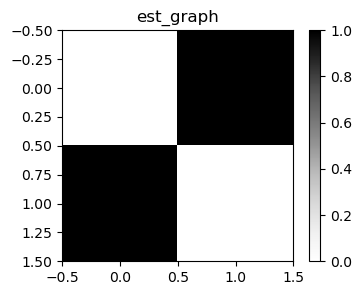

2025-04-23 17:52:54,142 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-04-23 17:52:55,242 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-04-23 17:52:56,258 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-04-23 17:52:56,886 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-04-23 17:52:57,998 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1026] - INFO: HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-04-23 17:52:59,007 - d:\WorkSoftware\Install\Anaconda3\Lib\s

In [18]:
import os
import re
import nltk
import random
import numpy as np
import pandas as pd
from ollama import generate
from ncastle.algorithms import RL
from datasets import load_dataset
from ncastle.common import GraphDAG
from collections import defaultdict
from BCEmbedding import EmbeddingModel
from sklearn.metrics import accuracy_score
from ragas import EvaluationDataset, evaluate
from langchain.embeddings import HuggingFaceEmbeddings
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from ragas.metrics import ContextRelevance, ContextRecall, ResponseRelevancy, Faithfulness

nltk.download('punkt')
nltk.download('punkt_tab')

# init embedding model
model = EmbeddingModel(model_name_or_path="maidalun1020/bce-embedding-base_v1")
# 初始化新的嵌入模型
emb_model_name = "maidalun1020/bce-embedding-base_v1"
model_kwargs = {'device': 'cuda'}
encode_kwargs = {'batch_size': 64, 'normalize_embeddings': True, 'show_progress_bar': False}
embed_model = HuggingFaceEmbeddings(
    model_name=emb_model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

os.environ["OPENAI_API_KEY"] = "sk-ow63M125nNhLojcnR6sKaO3SVRcZeXfeTEVe0Y4fjujHYCTq"
os.environ["OPENAI_API_BASE"] = "http://chatapi.littlewheat.com/v1"

model_name='llama3.1:8b'

# ========== STEP 1: Load SQuAD v1 validation split ==========
squad = load_dataset("squad", split="validation[:50]") 

# ========== STEP 2: Build TF-IDF retriever over all contexts ==========
all_contexts = list({ex["context"] for ex in squad})
vectorizer = TfidfVectorizer().fit(all_contexts)
tfidf_matrix = vectorizer.transform(all_contexts)

sentence_vectors = model.encode(all_contexts)

sentence_vectors = np.array(sentence_vectors, dtype=np.float64)
sentence_vectors = sentence_vectors.T
rl = RL(nb_epoch=2500,batch_size=8,device_type='gpu')
rl.learn(sentence_vectors)

GraphDAG(rl.causal_matrix)

causal_matrix = rl.causal_matrix
n = causal_matrix.shape[0]
causal_relations = []
for i in range(n):
    for j in range(n):
        if causal_matrix[i, j] != 0:
            causal_relations.append((i, j, causal_matrix[i, j]))

def get_all_causal_paths_iterative(start_idx, causes_map):
    all_paths = []
    stack = [(start_idx, [start_idx])]

    while stack:
        current_idx, path = stack.pop()

        if current_idx not in causes_map or not causes_map[current_idx]:
            all_paths.append(path)
            continue

        extended = False
        for cause_idx in causes_map[current_idx]:
            if cause_idx not in path:  # 防止环
                stack.append((cause_idx, path + [cause_idx]))
                extended = True

        if not extended:
            all_paths.append(path)

    return all_paths

def g_prompt(question, context, search_results, causal_relations):
    causes_map = defaultdict(list)
    for cause, effect, _ in causal_relations:
        causes_map[effect].append(cause)
    
    results = []

    seen_paths = set()
    global_path_idx = 1

    for i, sentence_idx in enumerate(search_results):
        results.append(context[sentence_idx])

        # 查找从当前句子出发的所有因果路径
        all_paths = get_all_causal_paths_iterative(sentence_idx, causes_map)

        if all_paths:
            for path in all_paths:
                # 统一路径方向：因果链从因到果（即从头到当前句子）
                path_reversed = list(reversed(path))
                path_tuple = tuple(path_reversed)

                # 防止重复路径展示
                if path_tuple in seen_paths:
                    continue
                seen_paths.add(path_tuple)

                for step_idx, idx in enumerate(path_reversed):
                    results.append(context[idx])
                global_path_idx += 1
    return list(set(results)
)

# def g_prompt(question, context, search_results, causal_relations):
#     causes_map = defaultdict(list)
#     for cause, effect, _ in causal_relations:
#         causes_map[effect].append(cause)
    
#     prompt_string = f"Question: {question}\n\n"

#     seen_paths = set()
#     global_path_idx = 1

#     for i, sentence_idx in enumerate(search_results):
#         prompt_string += f"Related Sentence {i + 1}: {context[sentence_idx]}\n"

#         # 查找从当前句子出发的所有因果路径
#         all_paths = get_all_causal_paths_iterative(sentence_idx, causes_map)

#         if all_paths:
#             prompt_string += "Causal Chain(s):\n"
#             for path in all_paths:
#                 # 统一路径方向：因果链从因到果（即从头到当前句子）
#                 path_reversed = list(reversed(path))
#                 path_tuple = tuple(path_reversed)

#                 # 防止重复路径展示
#                 if path_tuple in seen_paths:
#                     continue
#                 seen_paths.add(path_tuple)

#                 for step_idx, idx in enumerate(path_reversed):
#                     prompt_string += f"  Path {global_path_idx} - Step {step_idx + 1}: {context[idx]}\n"
#                 global_path_idx += 1
#     return prompt_string


def rl_retrieve_contexts(question, top_k=3):
    q_vec = vectorizer.transform([question])
    sims = cosine_similarity(q_vec, tfidf_matrix)[0]
    idxs = sims.argsort()[::-1][:top_k]
    return g_prompt(question,all_contexts,idxs,causal_relations)

# ========== STEP 3: Define Ollama LLM wrapper ==========
def extract_answer(response: str) -> str:
    # 去除所有 <think>...</think> 部分
    cleaned = re.sub(r"<think>.*?</think>", "", response, flags=re.DOTALL)
    return cleaned.strip()

def ask_ollama(prompt,model_name):    
    response = generate(
    model=model_name, 
    prompt=prompt
    )
    return response['response']

# 包装生成答案
def generate_answer(prompt,model_name):
    return extract_answer(ask_ollama(prompt,model_name))

# ========== STEP 4: Prepare DataFrame with required columns ==========
df = pd.DataFrame({
    "user_input": squad["question"],
    "context": squad["context"],
    "answers": [ans["text"] for ans in squad["answers"]],  # each is list[str]
})
df["retrieved_contexts"] = df["user_input"].apply(rl_retrieve_contexts)
df["retrieved_contexts"] = df["retrieved_contexts"].apply(lambda x: [x] if isinstance(x, str) else x)
df["reference"] = df["answers"].apply(lambda lst: lst[0] if lst else "")
# generate model responses conditioned on retrieved contexts
df["response"] = df.apply(
    lambda r: generate_answer(
        "Context:\n" + "\n".join(r["retrieved_contexts"]) +
        "\n\nQuestion: " + r["user_input"] + "\nAnswer:"
    , model_name),
    axis=1
)
if isinstance(df["reference"].iloc[0], (list, tuple)):
    df["reference"] = df["reference"].apply(lambda lst: lst[0] if lst else "")
df["reference"] = df["reference"].str.strip('"')
df["response"] = df["response"].apply(
    lambda r: (r["generations"][0]["text"] if isinstance(r, dict) and "generations" in r else str(r))
)

In [24]:
# ========== STEP 5: Build RAGas EvaluationDataset ==========
# Only the four fields user_input, retrieved_contexts, response, reference are needed.
eval_ds = EvaluationDataset.from_pandas(df[["user_input", "retrieved_contexts", "response", "reference"]])

# ========== STEP 6: Run evaluation ==========
rl_results = evaluate(
    dataset=eval_ds,
    metrics=[ContextRelevance(), ContextRecall(), ResponseRelevancy(), Faithfulness()],
)

# ========== STEP 7: Display results ==========
rl_results

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

2025-04-23 17:54:57,814 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1773] - INFO: HTTP Request: POST http://chatapi.littlewheat.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-23 17:54:57,875 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1773] - INFO: HTTP Request: POST http://chatapi.littlewheat.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-23 17:54:57,897 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1773] - INFO: HTTP Request: POST http://chatapi.littlewheat.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-23 17:54:57,928 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1773] - INFO: HTTP Request: POST http://chatapi.littlewheat.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-23 17:54:57,971 - d:\WorkSoftware\Install\Anaconda3\Lib\site-packages\httpx\_client.py[line:1773] - INFO: HTTP Request: POST http://chatapi.littlewheat.com/v1/chat/completions "HTTP/1.

{'nv_context_relevance': 0.9800, 'context_recall': 0.9400, 'answer_relevancy': 0.8826, 'faithfulness': 0.8963}